# **Загрузка библиотек**

In [109]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import nbformat
import plotly.graph_objects as go
import cmath 

from scipy.stats import normaltest, levene, norm
from scipy.optimize import curve_fit
from scipy.stats import f_oneway
from scipy.fft import fft, fftfreq, rfft, rfftfreq, irfft, ifft


sns.set_theme()
sns.set_palette("deep")

# **Acceleration in Booster measured with FCT 1-1**

## Booster parameters

In [110]:
mass_proton = 938.256 * 10**6 # масса покоя протона 
mass_proton_kg = 1.67252 * 10**(-24) # тоже самое только в кг (но нужно проверить)

mass_neutron = 938.2 * 10**6 # масса покоя нейрона 

mass_electron = 0.5111006 * 10**6 # масса покоя электрона 
charge_electron  = 1.6021 * 10**(-19) # заряд электрона в Кл 
e_conv = 299.7925 # ПОСМОТРЕТЬ (коэф перевода )
mass_electron_kg = 9.109383 * 10**(-28) # масса электрона кг
charge_electron_sgs = 4.80298 * 10*(-10) # заряд электрона СГС 


charge_number = 28 # зарядовое число 
mass_number = 124 # массовое число
booster_perimeter = 21096 # периметр бустера в мм


radius_proton  = (e_conv * charge_electron_sgs) / mass_proton # радиус протона 
radius_electron = (charge_electron_sgs * e_conv) / mass_electron # радиус электрона

phase = 1.38054 * 10**(-16) # ----
Z_n = 377 # --- 
c = 2.997925 * 10**10

## Data reading

In [111]:
number_data = 7 * 32 * 128 * 1024
delta_time = (50 * 10e5)**(-1)
    

In [116]:
booster_fct_file = r'E:\Project python\START_JINR\jinr_practice_3\booster_data\27_01_23_booster_fct_1.bin' # данные с быстрого трансформатора тока
booster_rf_file = r'E:\Project python\START_JINR\jinr_practice_3\booster_data\27_01_23_booster_rf_1.bin' # данные с задающего генератора ВЧ станции 

offset_signal_B = 45 # сдвиг начала 
offset_signal_RF = 10     
offset_end = 1500 # сдвиг конца
injection_period = 425.067 # период на энжекции (период можно высчетать как в прошлом файле)

number_period = np.floor(number_data / injection_period)

injection_period_length = np.arange(injection_period).astype(int)
   

In [117]:
singal_fast_current_transformer = np.fromfile(booster_fct_file, dtype='int16')[:number_data+1]
signal_RF_generator = np.fromfile(booster_rf_file, dtype='int16')[:number_data+1]

In [118]:
slice_start_data_B = injection_period_length + offset_signal_B
slice_last_data_B = (offset_signal_B + injection_period_length + np.floor(offset_end * injection_period)).astype(int)

slice_start_data_RF = injection_period_length + offset_signal_RF
slice_last_data_RF = (offset_signal_RF + injection_period_length + np.floor(offset_end * injection_period)).astype(int)

## Harmonic fitting for signal_RF_generator charge_numberero crossing

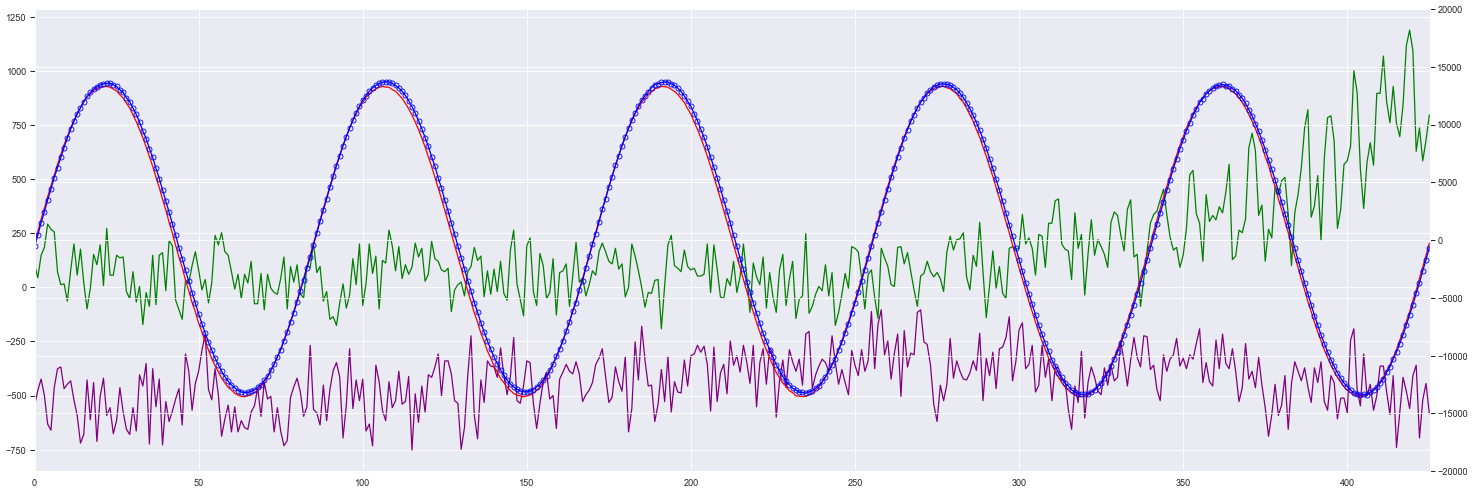

In [119]:
fig = plt.figure(figsize=(30, 10), dpi=60, facecolor="w", edgecolor="k")

plt.plot(injection_period_length, singal_fast_current_transformer[slice_start_data_B], color='green')
plt.plot(injection_period_length, singal_fast_current_transformer[slice_last_data_B], color='purple')

plt.twinx()
plt.plot(injection_period_length, signal_RF_generator[slice_start_data_RF], color='red')
plt.plot(injection_period_length, signal_RF_generator[slice_last_data_RF], marker='o', color='blue', markerfacecolor='none')

plt.xlim([0, injection_period])
plt.ylim([-2*10**(4), 2*10**4])


None

## signal_RF_generator data fiffing to the harmonic signal_RF_generator waveform from injection to intermidate flat top

In [120]:
def find_P_b_matrix(phase, L_i): #  пока оставить -----
    P_b = np.zeros((3, 3))
    cos_vals = np.cos(phase * np.arange(int(L_i) + 1))
    sin_vals = np.sin(phase * np.arange(int(L_i) + 1))

    P_b[0, 0] = np.sum(cos_vals**2)
    P_b[0, 1] = np.sum(cos_vals * sin_vals)
    P_b[0, 2] = np.sum(cos_vals)
    P_b[1, 0] = P_b[0, 1]
    P_b[1, 1] = np.sum(sin_vals**2)
    P_b[1, 2] = np.sum(sin_vals)
    P_b[2, 0] = P_b[0, 2]
    P_b[2, 1] = P_b[1, 2]
    P_b[2, 2] = L_i + 1

    return P_b

In [121]:
def zero_crossing(data, harmonic_HF, offset, start_period):
    n = offset
    iteration = 0
    period = start_period

    correlation_matrix  = []

    while n < (data.shape[0] - np.floor(period) - 1):

        phase = 2 * np.pi / period * harmonic_HF # связано со временеи обората, длинна сгустка - bunch ## похоже на фазу 

        period = int(period)

        harmonics_vector = np.zeros(3) # матрица гармоник от 0 до period 
        harmonics_vector[0] = np.sum(data[n:n + period + 1] * np.cos(phase * np.arange(period + 1)))
        harmonics_vector[1] = np.sum(data[n:n + period + 1] * np.sin(phase * np.arange(period + 1)))
        harmonics_vector[2] = np.sum(data[n:n + period + 1])

        P = find_P_b_matrix(phase, period)
        A = np.linalg.inv(P) @ harmonics_vector .T # ----

        correlation_vector = np.zeros(3) # матрица корреляций 
        correlation_vector[1] = np.sqrt(A[0]**2 + A[1]**2) # амплитуда 
        correlation_vector[0] = n + (1 / phase * np.arctan2(A[0], -A[1])) # фаза 
        correlation_vector[2] = A[2] # ----

        correlation_matrix.append(correlation_vector)

        n = int(np.floor(correlation_matrix[iteration][0] + period)) # перечет офсета 

        period = 1 / 10 * (correlation_matrix[iteration][0] - correlation_matrix[iteration-10][0]) if iteration > 12 else period # перечсет периода для окна 

        iteration += 1

    return correlation_matrix 


In [122]:
harmonic_HF = 5 # назвать лучше h - гармоника ВЧ

In [123]:
result = zero_crossing(signal_RF_generator, harmonic_HF, offset_signal_RF, injection_period) # набор матриц корреляций 
correlation_matrix = np.array(result)

In [124]:
number_rows_correlation_matrix = np.arange(len(correlation_matrix)-1)

In [125]:
st = np.array(list(map(lambda x: np.floor(x[0]), correlation_matrix[1:]))) # в какой-то степени нормировка амплитуды

In [126]:
beta = np.array([booster_perimeter/ (c * delta_time * (correlation_matrix[index+1][0] - correlation_matrix[index][0])) for index in number_rows_correlation_matrix]) # Лоренс фактор 

gamma = 1 / np.sqrt(1 - beta**2) # Лоренс фактор 

total_energy = (gamma - 1) * mass_proton # Полная энергия 

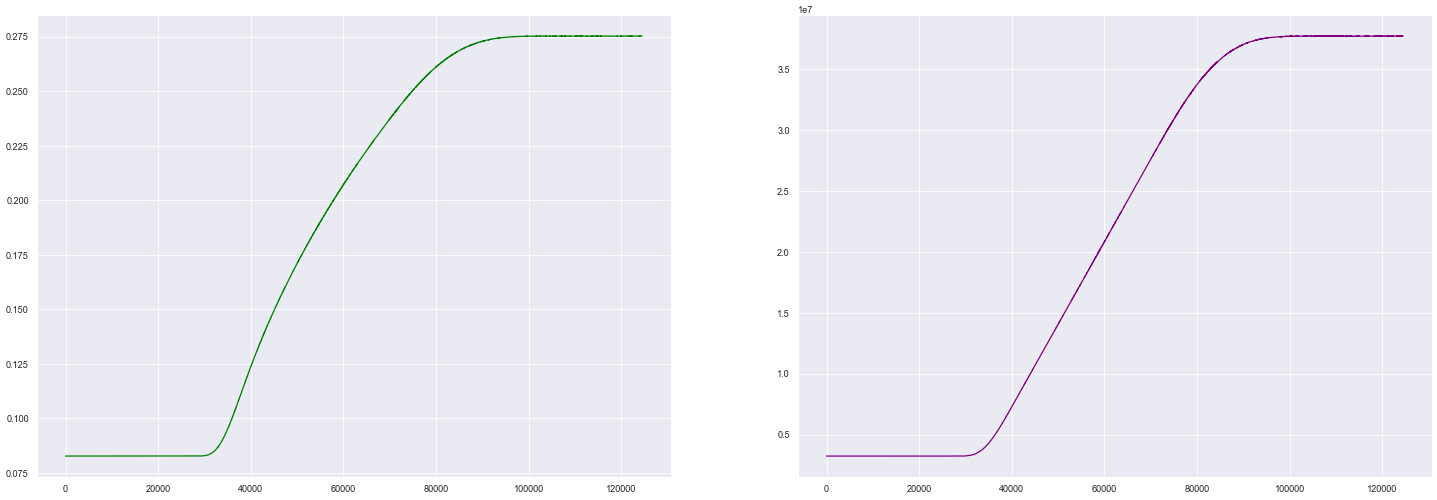

In [127]:
fig = plt.figure(figsize=(30, 10), dpi=60, facecolor="w", edgecolor="k")

plt.subplot(1,2,1)
plt.plot(number_rows_correlation_matrix, beta, color='green')

plt.subplot(1,2,2)
plt.plot(number_rows_correlation_matrix, total_energy, color='purple')

None

In [128]:
phase_difference_RF = np.array([correlation_matrix[index+1][0] - correlation_matrix[index][0] for index in number_rows_correlation_matrix]) # разность фаз ## изменение фазы ВЧ

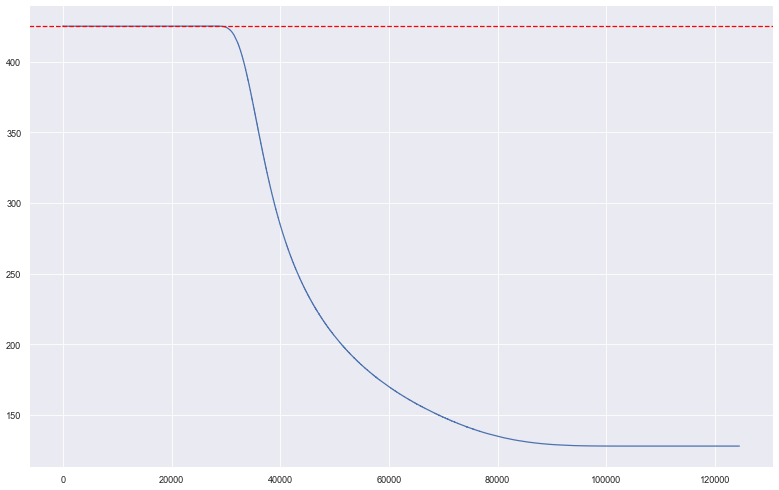

In [129]:
fig = plt.figure(figsize=(16, 10), dpi=60, facecolor="w", edgecolor="k")

plt.plot(number_rows_correlation_matrix, phase_difference_RF)

plt.axhline(y=injection_period, color='red', ls='--')

None

In [130]:
number_window_samples = 70_000 # начало построения окна в отчетах для графика 
delta_iB = 10 # смещение для графика 

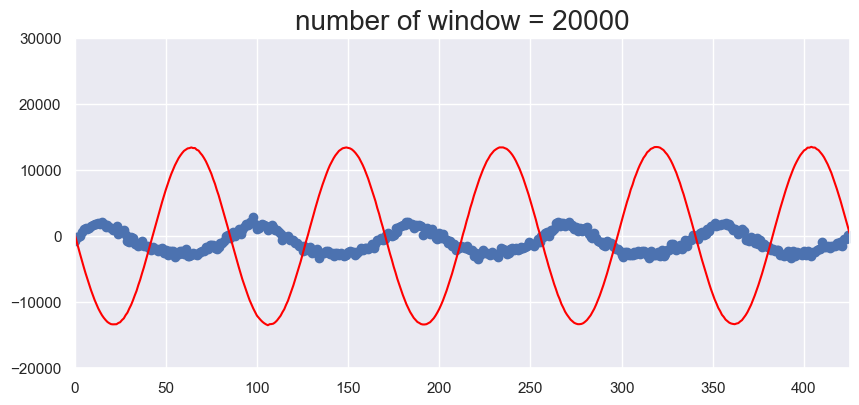

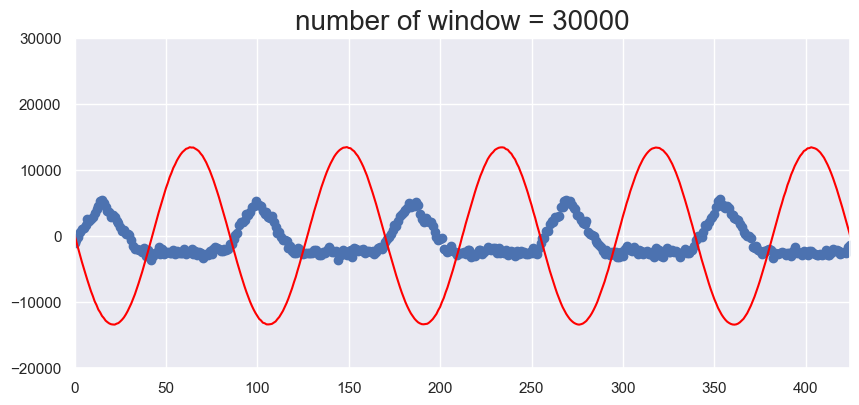

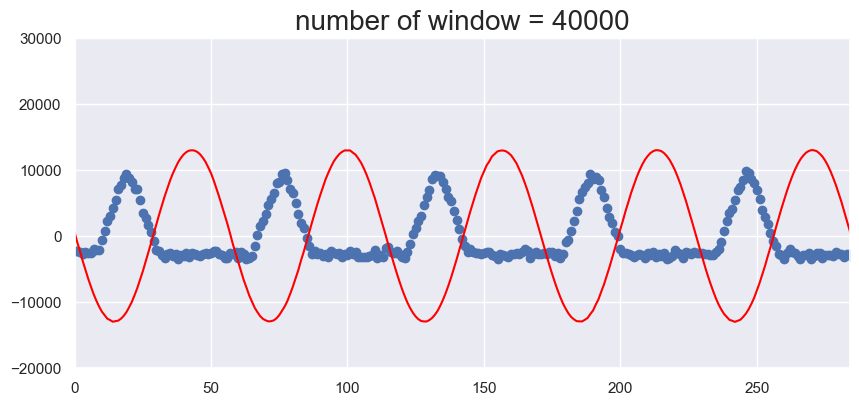

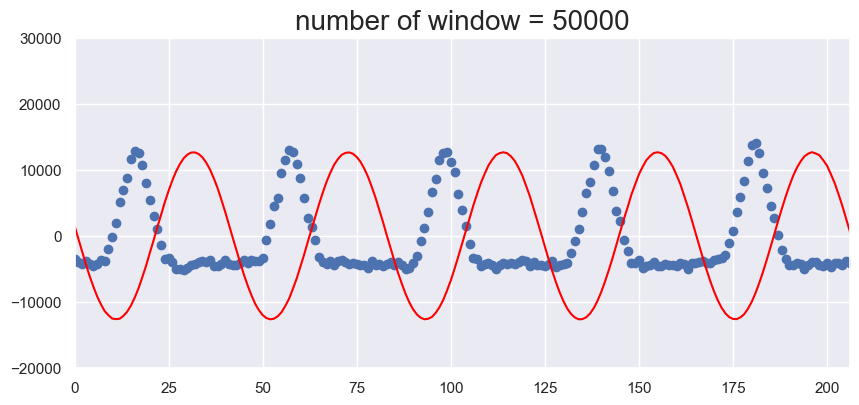

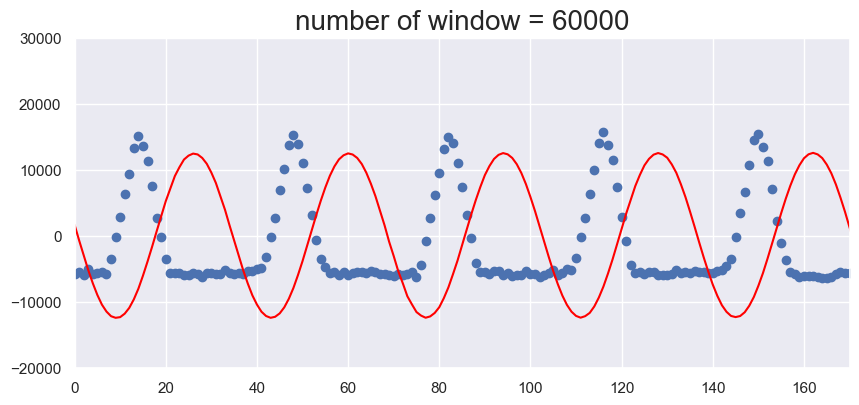

In [131]:
for window_samples in range(20_000, number_window_samples, 10_000):
    
    data_1 = signal_RF_generator[(injection_period_length + st[window_samples]).astype(int)] - correlation_matrix[window_samples][2]
    data_2 = 3 * singal_fast_current_transformer[(injection_period_length + st[window_samples] + delta_iB).astype(int)]


    plt.subplots(figsize=(10, 30))
    plt.subplot(6,1, window_samples // 10_000)
    
    plt.title(f'number of window = {window_samples}', fontsize=20)
    plt.plot(injection_period_length, data_1, color='red')
    plt.scatter(injection_period_length, data_2)

    plt.xlim([0, st[window_samples+1]-st[window_samples]])
    plt.ylim([-2*10**4, 3*10**4])
    
    None

вопрос по поводу того, что фаза 10 к и 20 к отличается от основного сигнала 

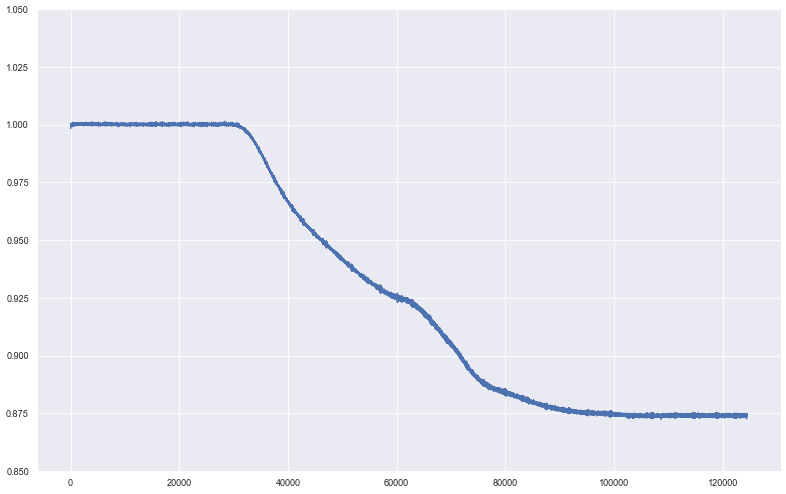

In [132]:
fig = plt.figure(figsize=(16, 10), dpi=60, facecolor="w", edgecolor="k")

plt.plot(number_rows_correlation_matrix, correlation_matrix[number_rows_correlation_matrix, 1] / correlation_matrix[0,1]) # нормировка фазы на начальную 

plt.ylim([0.85, 1.05])

None

In [ ]:
window = 6 # окно усреднения 

In [ ]:
def get_minimum(data, period, offset, window): # сглаживание усреднием и поиск минимуна по усредненному сигналу 

    injection_period_length = np.arange(period) + offset

    window_sum = np.convolve(data[injection_period_length], np.ones(window*2 + 1), mode='valid') # сглаживание усреднением
    
    V = window_sum / (2 * window + 1)
    
    correlation_vector = np.min(V)
    
    return correlation_vector

In [ ]:
correct_number_rows_correlation_matrix = np.arange(2, len(correlation_matrix) - 2)

list_averaged_signal_minima = [get_minimum(singal_fast_current_transformer, int(st[injection_period_length + 1] - st[injection_period_length]), int(st[injection_period_length] + delta_iB), window) for injection_period_length in correct_number_rows_correlation_matrix]

list_averaged_signal_minima = np.array(list_averaged_signal_minima)

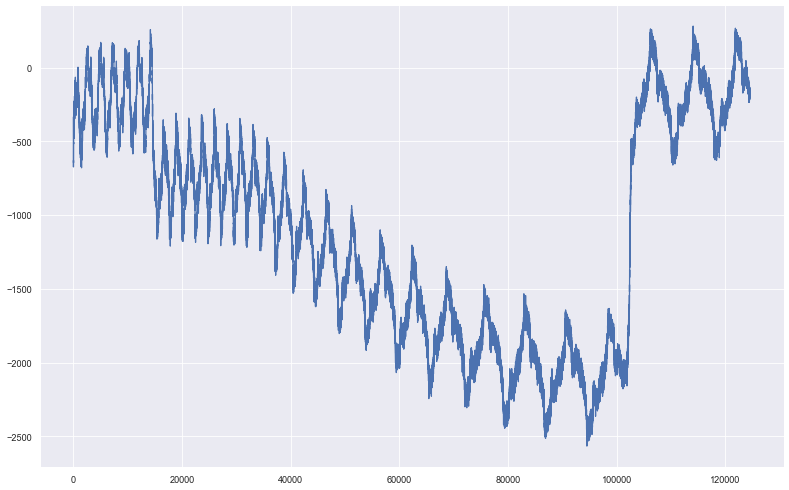

In [ ]:
fig = plt.figure(figsize=(16, 10), dpi=60, facecolor="w", edgecolor="k")

plt.plot(correct_number_rows_correlation_matrix, list_averaged_signal_minima)

None

In [ ]:
N_ion = np.zeros(len(correct_number_rows_correlation_matrix)) # интенсивность пучка в частицах 

for injection_period_length in correct_number_rows_correlation_matrix: 
    N_ion[injection_period_length-2] = 8.6 * 10**(-5) * (10**(-3) / (5 * charge_number)) * (delta_time / charge_electron) * np.sum(singal_fast_current_transformer[int(st[injection_period_length] + delta_iB): int(st[injection_period_length+1] + delta_iB + 1)] - list_averaged_signal_minima[injection_period_length-2])

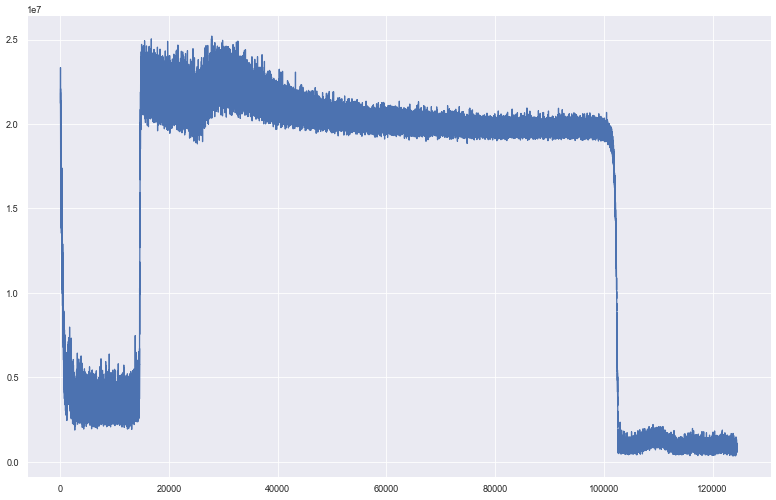

In [ ]:
fig = plt.figure(figsize=(16, 10), dpi=60, facecolor="w", edgecolor="k")

plt.plot(correct_number_rows_correlation_matrix, N_ion)

None

In [ ]:
fi = np.zeros(len(correct_number_rows_correlation_matrix)) # фаза в градусах 

for injection_period_length in correct_number_rows_correlation_matrix:
    up_sum = np.sum((singal_fast_current_transformer[int(st[injection_period_length] + delta_iB): int(st[injection_period_length+1] + delta_iB + 1)] - list_averaged_signal_minima[injection_period_length-2]) * (np.arange(st[injection_period_length+1]-st[injection_period_length]+1) + st[injection_period_length] - (correlation_vector[injection_period_length+2, 0] + correlation_vector[injection_period_length+1, 0]) / 2))
    
    under_sum = np.sum(singal_fast_current_transformer[int(st[injection_period_length] + delta_iB): int(st[injection_period_length+1] + delta_iB + 1)] - list_averaged_signal_minima[injection_period_length-2])

    fi[injection_period_length-2] = 360 * harmonic_HF / (st[injection_period_length+1] - st[injection_period_length]) * (up_sum / under_sum) # коэффициент поправки для выравнивания сигналов относительно нуля 

    # st[injection_period_length+1] - st[injection_period_length] - delta_fi 

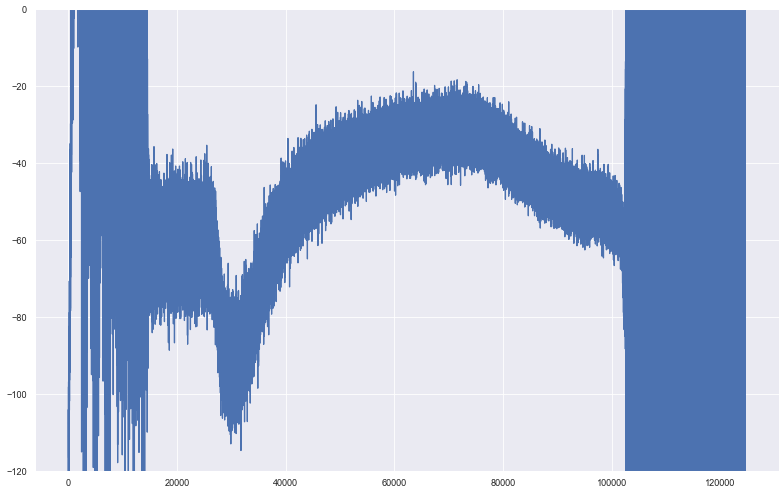

In [ ]:
fig = plt.figure(figsize=(16, 10), dpi=60, facecolor="w", edgecolor="k")

plt.plot(correct_number_rows_correlation_matrix, fi)

plt.ylim([-120, 0])

None

In [ ]:
N_av = 20 # новое окно для усреднения 

n_a = np.arange(np.floor(len(correlation_matrix) / 20) - 1).astype(int)

In [ ]:
fi_a = np.zeros(len(n_a)) # фильтрация фазы 
fi = np.hstack((np.zeros(2), fi)) 

for injection_period_length in n_a:
    fi_a[injection_period_length] = 1 / N_av * np.sum(fi[injection_period_length * N_av:injection_period_length * N_av + N_av])

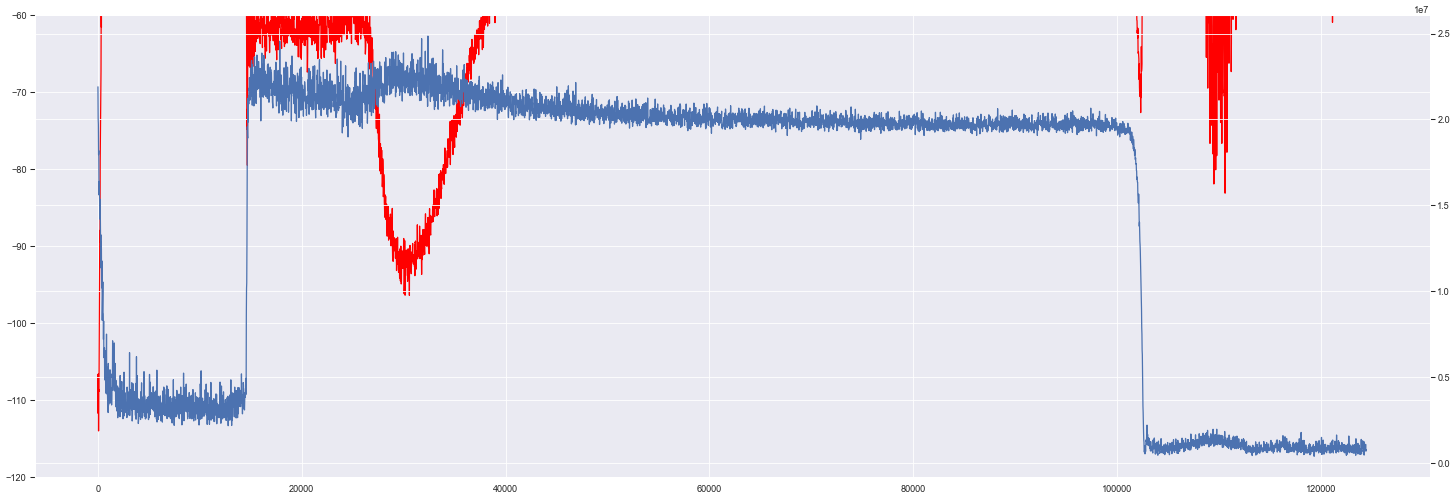

In [ ]:
fig = plt.figure(figsize=(30, 10), dpi=60, facecolor="w", edgecolor="k")

plt.plot(N_av * n_a, fi_a, color='red')

plt.ylim([-120, -60])

plt.twinx()
plt.plot(N_av * n_a, N_ion[n_a*N_av])


None

# N_av * n_a - учет усреднений для графиков 

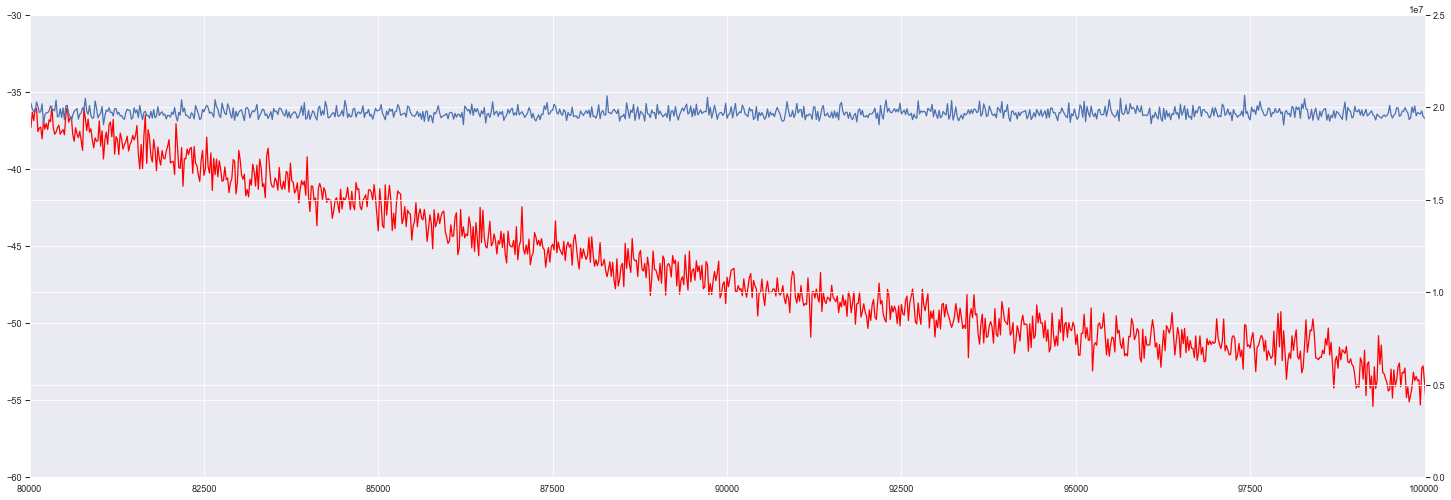

In [ ]:
fig = plt.figure(figsize=(30, 10), dpi=60, facecolor="w", edgecolor="k")

plt.plot(N_av * n_a, fi_a, color='red')

plt.ylim([-60, -30])
plt.xlim([8*10**4, 10**5])

plt.twinx()
plt.plot(N_av * n_a, N_ion[n_a*N_av])

plt.ylim([0, 2.5*10**7])

None

# **Data writing**

In [ ]:
file_name = r'BoosterAcceleration1_1half.dat'

In [ ]:
O = np.dstack((correlation_matrix[2:-2,0], N_ion, fi[2:]))

In [ ]:
with open(file_name, "wb") as file:
    np.save(file, O)